# Evaluation of models
Notebook to evaluate visually models

It randomly finds predictions that are either FP, FN or good call by comapring 
predictions from model to ground truth labels.

In [32]:
import utils.utils_loading as utils_load
import numpy as np
import nibabel as nib
import pickle
import os
import random
import glob
from scipy.ndimage import label, measurements
import matplotlib.pyplot as plt

# processed  data dir
data_dir = "/home/cerebriu/data/datasets/VALDO_processed_v2/Data"

# prediciton data stored in standard folder structure from ClearML
pred_dir2 = "/home/cerebriu/data/datasets/ResearchProject/valdo-3Dunet-pred" # experiment 2
pred_dir3 = "/home/cerebriu/data/datasets/ResearchProject/valdo-3Dunet-pred_diceloss" # experiment 3

In [33]:
valid_studies = os.listdir(pred_dir2)
print(f"Studies in validation split: {valid_studies}")

Studies in validation split: ['sub-232', 'sub-219', 'sub-202', 'sub-104', 'sub-106', 'sub-221', 'sub-222', 'sub-229', 'sub-208', 'sub-214', 'sub-204', 'sub-309', 'sub-312', 'sub-314', 'sub-213', 'sub-311', 'sub-206', 'sub-217', 'sub-307', 'sub-226', 'sub-303', 'sub-302']


In [34]:
def read_cmb_pred(p_dir, sub):
    pred_file = glob.glob(f"{p_dir}/sub-{sub}/predictions/*/*.nii.gz")[0]
    im = nib.load(pred_file)
    return im

def adjust_for_radiological_view(image):
    return np.rot90(image)

def plot_subject(sub, data_dir, pred_dir, axs, row, col, plot_type='good'):
    cmb, mri, _, _ = utils_load.read_data_processed(sub, data_dir)
    cmb_pred = read_cmb_pred(pred_dir, sub)

    # Data
    cmb_data, mri_data, cmb_pred_data = cmb.get_fdata(), mri.get_fdata()[..., 0], cmb_pred.get_fdata()

    # Optionally find and plot false positives
    centers_of_mass = []
    if plot_type=="fp":
        centers_of_mass = find_false_positives(cmb_data, cmb_pred_data)
        # Logic to plot false positives
    elif plot_type=="fn":
        centers_of_mass = find_false_negatives(cmb_data, cmb_pred_data)
        # Logic to plot false negatives
    elif plot_type=='good':
        # Label connected components and compute centers of mass for each component
        labeled_array, num_features = label(cmb_data)
        if num_features == 0:
            return False  # No connected components found
        centers_of_mass = measurements.center_of_mass(cmb_data, labeled_array, range(1, num_features + 1))

    if centers_of_mass is None or len(centers_of_mass)==0:
        return False
    
    # Choose the first center of mass
    chosen_cmb = random.randint(0, len(centers_of_mass)-1)
    CM = tuple(int(coord) for coord in centers_of_mass[chosen_cmb])

    # Define the size of the patch (80 voxels in each dimension)
    patch_size = 80
    half_size = patch_size // 2

    # Calculate the start and end indices for the crop
    start_idx = [max(0, cm - half_size) for cm in CM]
    end_idx = [min(dim, cm + half_size) for cm, dim in zip(CM, mri_data.shape)]

    # Create slices for cropping
    crop_slice = tuple(slice(start, end) for start, end in zip(start_idx, end_idx))

    # Apply cropping
    t2s_data_cropped = mri_data[crop_slice]
    cmb_cropped = cmb_data[crop_slice]
    pred_cmb_cropped = cmb_pred_data[crop_slice]

    # Plotting
    axs[row, col].imshow(adjust_for_radiological_view(t2s_data_cropped[:, :, half_size]), cmap='gray')
    axs[row, col].set_title(f'Sub {sub}: T2S')

    axs[row, col+1].imshow(adjust_for_radiological_view(t2s_data_cropped[:, :, half_size]), cmap='gray')
    axs[row, col+1].imshow(adjust_for_radiological_view(cmb_cropped[:, :, half_size]), alpha=0.7, cmap="Reds", interpolation='none')
    axs[row, col+1].set_title(f'Sub {sub}: T2S + GT')

    axs[row, col+2].imshow(adjust_for_radiological_view(t2s_data_cropped[:, :, half_size]), cmap='gray')
    axs[row, col+2].imshow(adjust_for_radiological_view(pred_cmb_cropped[:, :, half_size]), alpha=0.7, cmap="Reds", interpolation='none')
    axs[row, col+2].set_title(f'Sub {sub}: T2S + Prediction')

    return {"subject": sub, "CM": CM}


def find_false_positives(cmb_data, cmb_pred_data):
    labeled_array_actual, _ = label(cmb_data)
    cmb_pred_data = np.squeeze(cmb_pred_data)
    labeled_array_pred, num_features_pred = label(cmb_pred_data)

    false_positives = []
    for component in range(1, num_features_pred + 1):
        
        component_mask = labeled_array_pred == component
        component_mask = component_mask
        overlap = np.any(cmb_data[component_mask])

        if not overlap:
            com = measurements.center_of_mass(cmb_pred_data, labeled_array_pred, component)
            false_positives.append(tuple(map(round, com)))

    return false_positives

def find_false_negatives(cmb_data, cmb_pred_data):
    labeled_array_actual, num_features_actual = label(cmb_data)
    labeled_array_pred, _ = label(cmb_pred_data)
    labeled_array_pred = np.squeeze(labeled_array_pred)

    false_negatives = []
    for component in range(1, num_features_actual + 1):
        component_mask = labeled_array_actual == component
        component_mask = component_mask
        overlap = np.any(cmb_pred_data[component_mask])

        if not overlap:
            com = measurements.center_of_mass(cmb_data, labeled_array_actual, component)
            false_negatives.append(tuple(map(round, com)))

    return false_negatives

### Randomly shuffle eval set and start looking for cases of interest

We do so in Model 3, where it is harder to find FPs

/tmp/ipykernel_796145/2322523582.py:29: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centers_of_mass = measurements.center_of_mass(cmb_data, labeled_array, range(1, num_features + 1))
/tmp/ipykernel_796145/2322523582.py:99: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  com = measurements.center_of_mass(cmb_data, labeled_array_actual, component)
/tmp/ipykernel_796145/2322523582.py:82: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  com = measurements.center_of_mass(cmb_pred_data, labeled_array_pred, component)


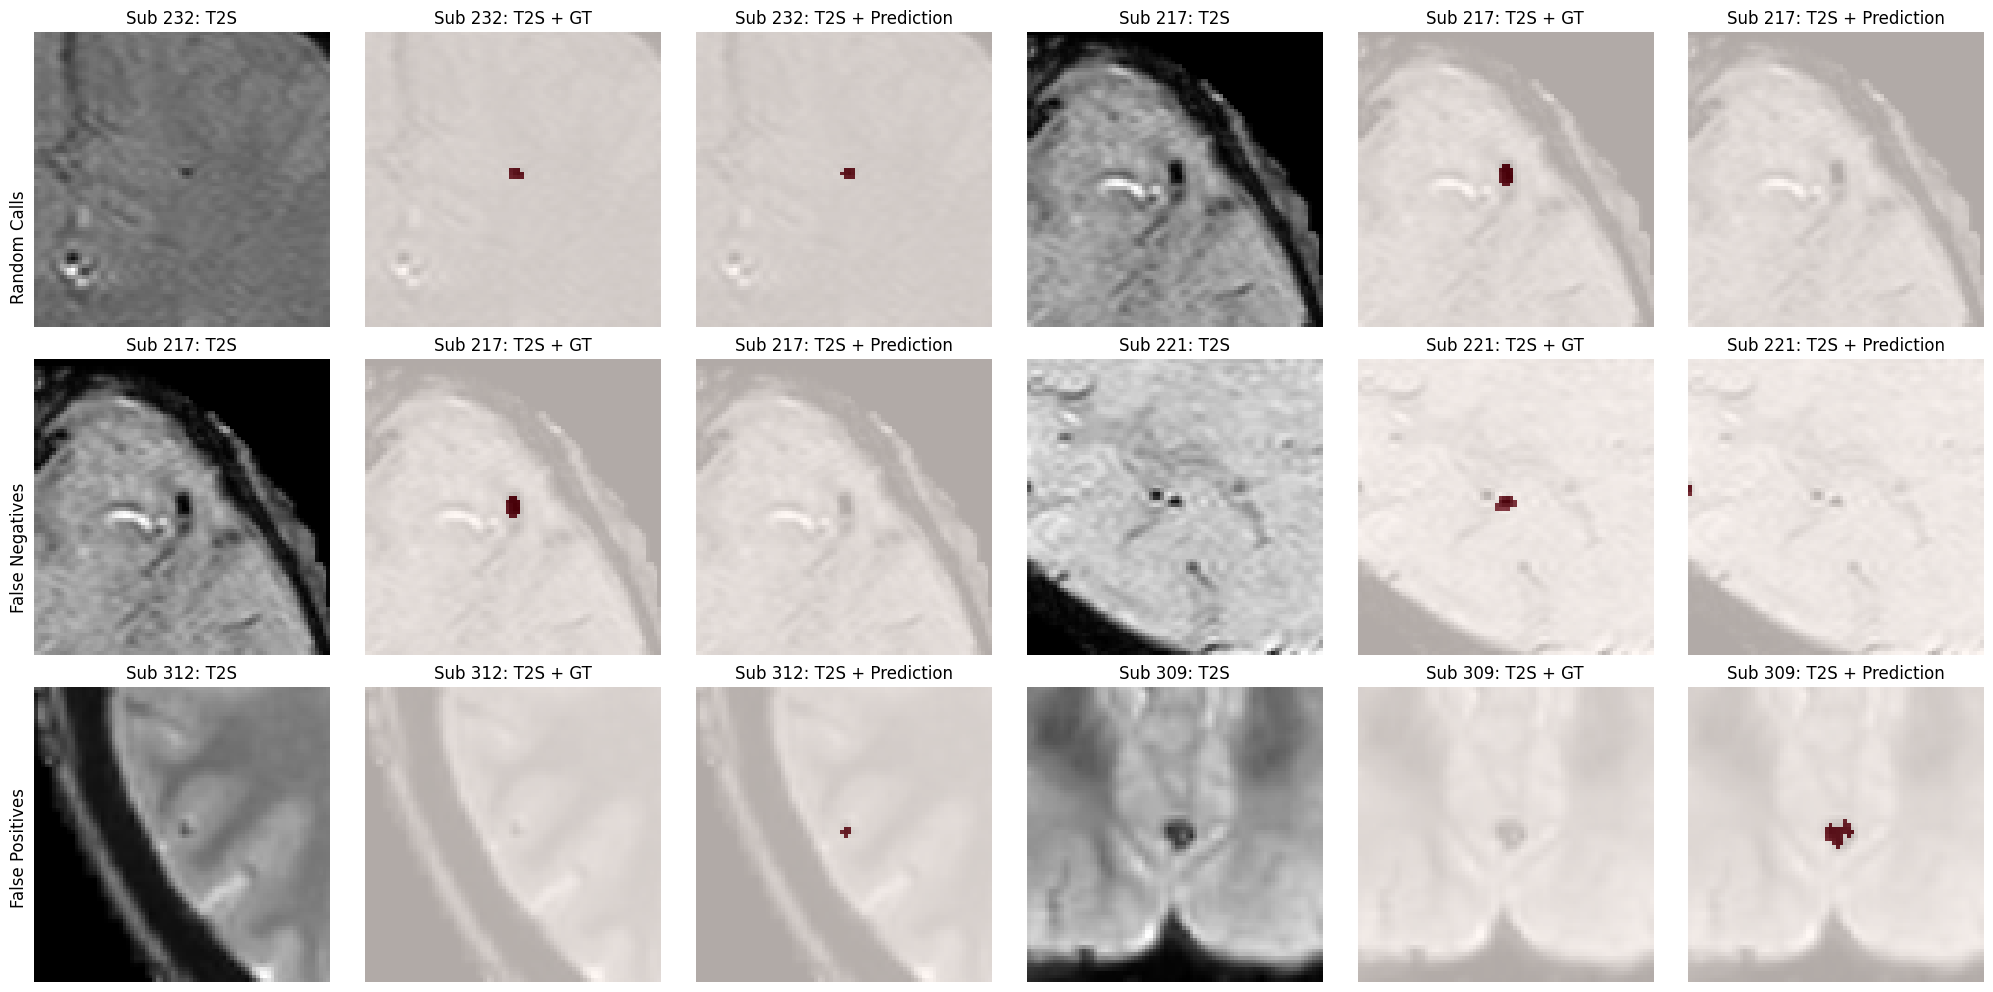

In [35]:
import random

randomized_studies = valid_studies.copy()

# Randomize the order of subjects
random.shuffle(randomized_studies)

# Create iterators for each category based on the randomized list
good_calls_subjects = iter(randomized_studies)
random.shuffle(randomized_studies)
fn_subjects = iter(randomized_studies)
random.shuffle(randomized_studies)
fp_subjects = iter(randomized_studies)

# Creating a figure with 3x6 subplots
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
plot_results= {}


for i in range(2):  # Two subjects per category
    # Plot Good Calls
    while True:
        try:
            sub = next(good_calls_subjects).split("-")[1]
            result = plot_subject(sub, data_dir, pred_dir3, axs, 0, i * 3)
            if result:
                plot_results[('good', i)] = result
                break
        except StopIteration:
            break

    # Plot False Negatives
    while True:
        try:
            sub = next(fn_subjects).split("-")[1]
            result = plot_subject(sub, data_dir, pred_dir3, axs, 1, i * 3, plot_type='fn')
            if result:
                plot_results[('fn', i)] = result
                break
        except StopIteration:
            break

    # Plot False Positives
    while True:
        try:
            sub = next(fp_subjects).split("-")[1]
            result = plot_subject(sub, data_dir, pred_dir3, axs, 2, i * 3, plot_type='fp')
            if result:
                plot_results[('fp', i)] = result
                break
        except StopIteration:
            break

# Turn off unused axes
for ax in axs.flat:
    ax.axis('off')

# Add annotations for each row
fig.text(0.005, 0.75, 'Random Calls', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.005, 0.45, 'False Negatives', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.005, 0.15, 'False Positives', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()

In [36]:
plot_results

{('good', 0): {'subject': '232', 'CM': (167, 268, 160)},
 ('fn', 0): {'subject': '217', 'CM': (223, 228, 121)},
 ('fp', 0): {'subject': '312', 'CM': (56, 93, 184)},
 ('good', 1): {'subject': '217', 'CM': (223, 227, 121)},
 ('fn', 1): {'subject': '221', 'CM': (101, 81, 212)},
 ('fp', 1): {'subject': '309', 'CM': (156, 75, 55)}}

In [37]:
# # Save if interesting
# import pickle 
# file_pi = open('/home/cerebriu/data/datasets/ResearchProject/plot_info2.obj', 'wb') 
# pickle.dump(plot_results, file_pi)
# file_pi.close()

In [38]:
# # Path to the saved file
# file_path = '/home/cerebriu/data/datasets/ResearchProject/plot_info2.obj'

# # Open the file for reading
# with open(file_path, 'rb') as file_pi:
#     plot_results = pickle.load(file_pi)

# plot_results

In [39]:
# # Path to the saved file
# file_path = '/home/cerebriu/data/datasets/ResearchProject/plot_info1.obj'

# # Open the file for reading
# with open(file_path, 'rb') as file_pi:
#     plot_info1 = pickle.load(file_pi)
    
# plot_info1

In [40]:
def plot_subject_from_info(sub, CM, data_dir, pred_dir, axs, row, col):
    # Load data from the new data directory
    cmb, mri, _, _ = utils_load.read_data_processed(sub, data_dir)
    cmb_pred = read_cmb_pred(pred_dir, sub)

    # Data
    cmb_data, mri_data, cmb_pred_data = cmb.get_fdata(), mri.get_fdata()[..., 0], cmb_pred.get_fdata()

    # Calculate the start and end indices for the crop
    patch_size = 80
    half_size = patch_size // 2
    start_idx = [max(0, cm - half_size) for cm in CM]
    end_idx = [min(dim, cm + half_size) for cm, dim in zip(CM, mri_data.shape)]

    # Create slices for cropping
    crop_slice = tuple(slice(start, end) for start, end in zip(start_idx, end_idx))

    # Apply cropping
    t2s_data_cropped = mri_data[crop_slice]
    cmb_cropped = cmb_data[crop_slice]
    pred_cmb_cropped = cmb_pred_data[crop_slice]

    # Plotting
    axs[row, col].imshow(np.rot90(t2s_data_cropped[:, :, half_size]), cmap='gray')
    axs[row, col].set_title(f'Sub {sub}: T2S')

    axs[row, col+1].imshow(np.rot90(t2s_data_cropped[:, :, half_size]), cmap='gray')
    axs[row, col+1].imshow(np.rot90(cmb_cropped[:, :, half_size]), alpha=0.7, cmap="Greens", interpolation='none')
    axs[row, col+1].set_title(f'Sub {sub}: GT')

    axs[row, col+2].imshow(np.rot90(t2s_data_cropped[:, :, half_size]), cmap='gray')
    axs[row, col+2].imshow(np.rot90(pred_cmb_cropped[:, :, half_size]), alpha=0.7, cmap="Reds", interpolation='none')
    axs[row, col+2].set_title(f'Sub {sub}: Pred')
    
    return axs

In [41]:
# These cases were manually selected after several iterations of previosu cells
selected4plot = {
    ('good', 0): {'subject': '221', 'CM': (126, 55, 219)},
    ('good', 1): {'subject': '311', 'CM': (224, 220, 92)},
    ('fn', 0): {'subject': '217', 'CM': (223, 228, 121)},
    ('fn', 1): {'subject': '222', 'CM': (111, 288, 238)},
    ('fp', 0): {'subject': '314', 'CM': (146, 279, 174)},
    ('fp', 1): {'subject': '106', 'CM': (128, 39, 94)}
}

## Model 2
patch size 80x, tversky loss $\alpha$=0.3, $\beta$=0.7

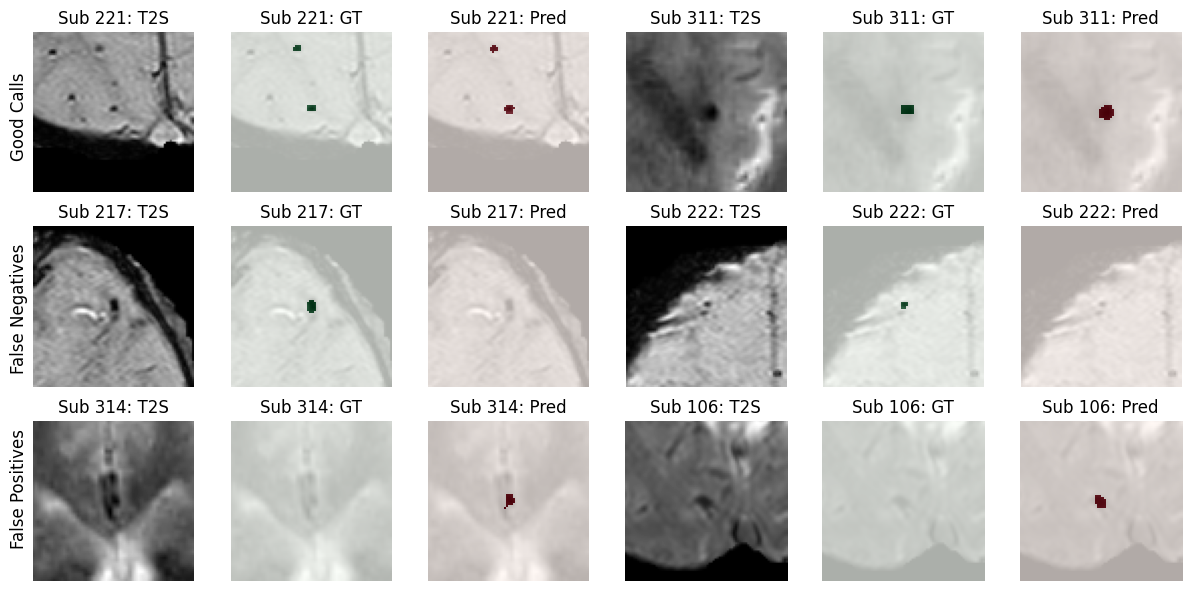

In [42]:


# Creating a new figure with 3x6 subplots
fig, axs = plt.subplots(3, 6, figsize=(12, 6))

# Loop through the selected4plot dictionary and plot
for key, value in selected4plot.items():
    category, index = key
    subject_info = value
    sub = subject_info['subject']
    CM = subject_info['CM']
    row = {'good': 0, 'fn': 1, 'fp': 2}[category]
    col = index * 3  # Each subject occupies 3 columns

    axs = plot_subject_from_info(sub, CM, data_dir, pred_dir2, axs, row, col)

# Turn off unused axes and add annotations
for ax in axs.flat:
    ax.axis('off')

# Add annotations for each row
fig.text(0.01, 0.80, 'Good Calls', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.01, 0.48, 'False Negatives', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.01, 0.18, 'False Positives', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

plt.savefig('../img/patch_predictions_model2.png', dpi=500)

plt.show()


## Model 3
patch size 80x, tversky loss $\alpha$=0.5, $\beta$=0.5 (Dice score)

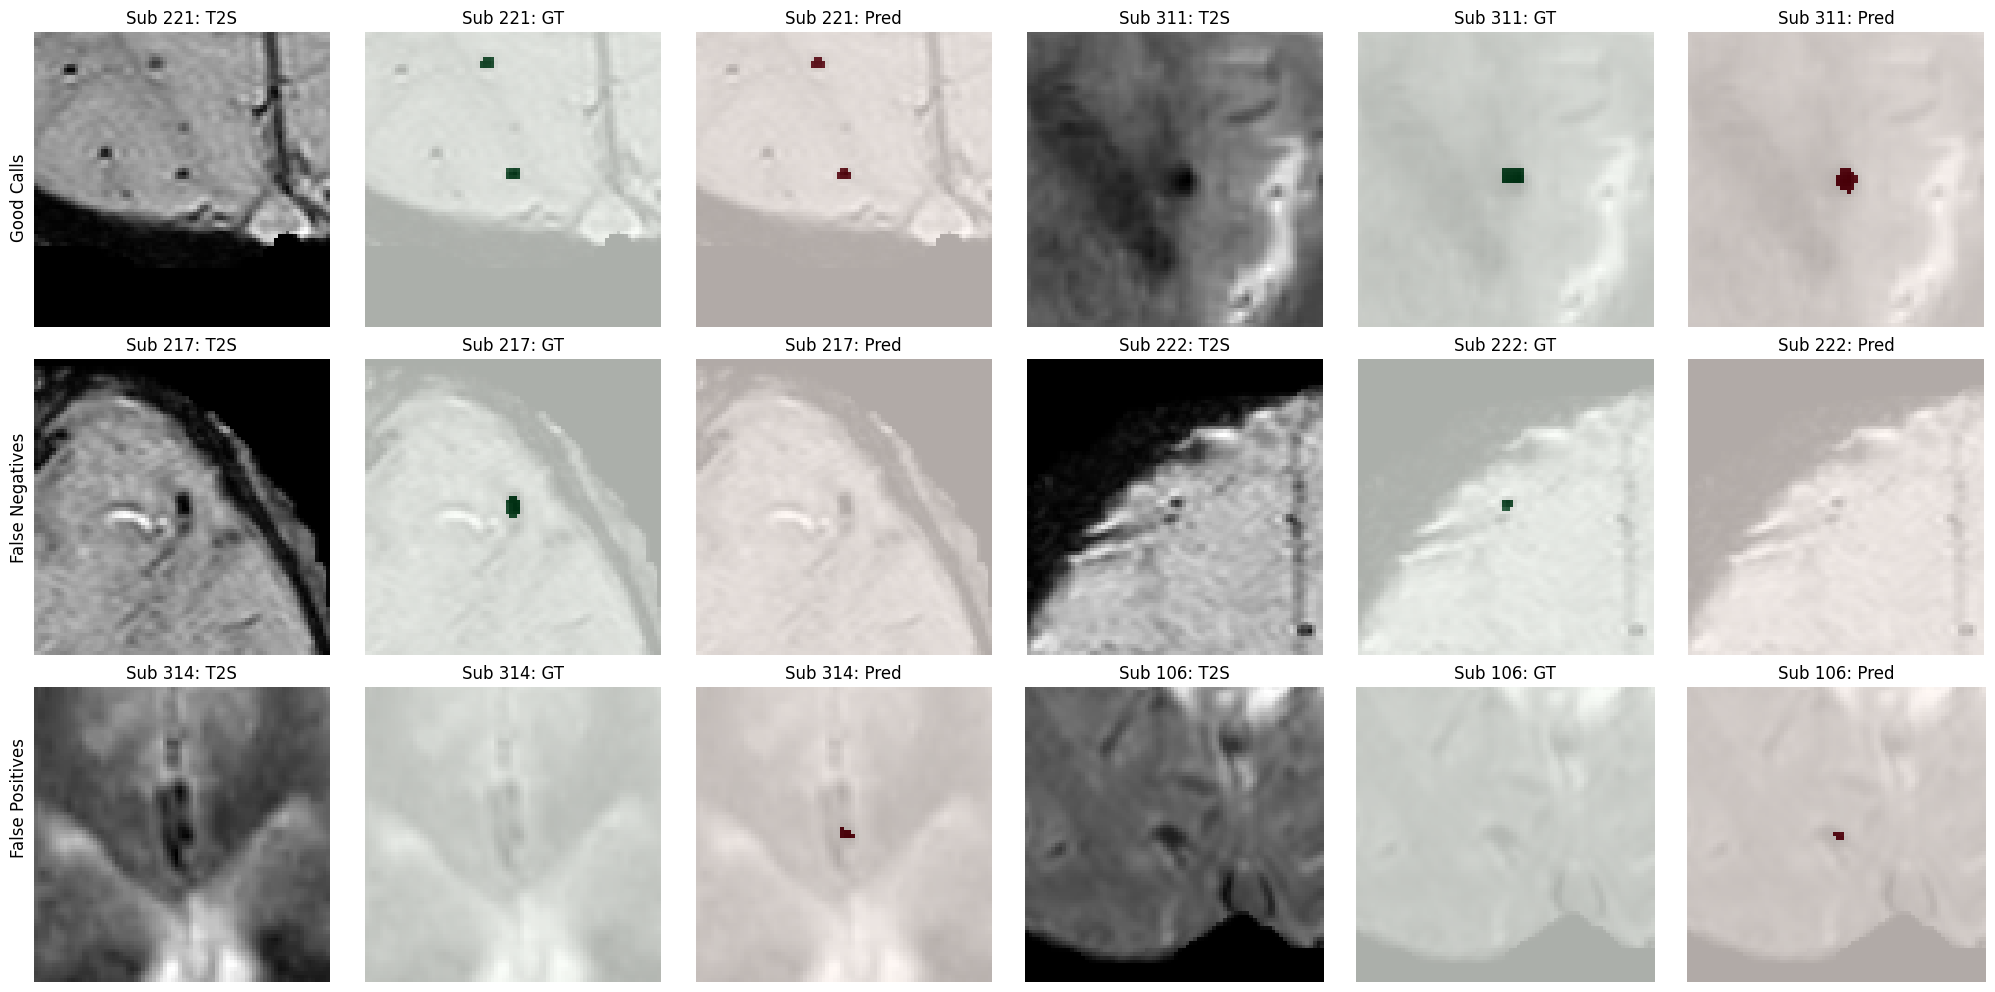

In [43]:
# Creating a new figure with 3x6 subplots
fig, axs = plt.subplots(3, 6, figsize=(20, 10))

# Loop through the selected4plot dictionary and plot
for key, value in selected4plot.items():
    category, index = key
    subject_info = value
    sub = subject_info['subject']
    CM = subject_info['CM']
    row = {'good': 0, 'fn': 1, 'fp': 2}[category]
    col = index * 3  # Each subject occupies 3 columns

    axs = plot_subject_from_info(sub, CM, data_dir, pred_dir3, axs, row, col)

# Turn off unused axes and add annotations
for ax in axs.flat:
    ax.axis('off')

# Add annotations for each row
fig.text(0.005, 0.80, 'Good Calls', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.005, 0.50, 'False Negatives', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.005, 0.20, 'False Positives', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

plt.savefig('../img/patch_predictions_model3.png', dpi=500)

plt.show()